# Jet pt and mass "inverting" regression with omnifold

In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import uproot
import aiohttp
from matplotlib import pyplot as plt
import awkward as ak
from keras.layers import Dense, Input
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

import omnifold 
from omnifold import DataLoader, MultiFold, MLP, SetStyle, HistRoutine
import os
import tensorflow as tf
import coffea
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import matplotlib as mpl
#####
#Delta R matched

2024-10-18 17:46:07.553325: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-18 17:46:07.558353: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-18 17:46:07.570652: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 17:46:07.595013: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 17:46:07.602216: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 17:46:07.620664: I tensorflow/core/platform/cpu_feature_gu

Horovod not found, will continue with single only GPUs.


/opt/conda/lib/python3.11/site-packages/coffea/nanoevents/schemas/fcc.py:5: FutureWarning: In version 2025.1.0 (target date: 2024-12-31 11:59:59-06:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"]=False 

In [3]:
coffea.__version__

'2024.10.0'

### Check to see if a GPU is present for acceleration

### Get leading generator-level ("truth" or "gen") jet and match to the nearest reconstructed-level ("reco") jet

In [4]:
#coffea init
cofevents = NanoEventsFactory.from_root( {'QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8_NANOAODSIM_7F142AC6-39F2-2F4F-9F97-C425A1C99A35.root':'Events'}, schemaclass=NanoAODSchema).events()
####

# Filter 0s 
cevents = cofevents[ak.num(cofevents.FatJet)>0]
cevents = cevents[ak.num(cevents.GenJetAK8)>0]
fj = cevents.FatJet
gj = cevents.GenJetAK8


#this should give fatjets closest to genjets, and since genjets are already stripped of zeroes, this should just line up (pfft just kidding)
nearest_fj = gj.nearest(fj)

gj0 = gj[:,0]          # Leading generator-level (gen) jet
fj0 = nearest_fj[:,0]  # Reco jet that matches leading gen jet

/opt/conda/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_electronIdx => Electron
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/coffea/nanoevents/schemas/nanoaod.py:264: RuntimeWarning: Missing cross-reference index for LowPtElectron_photonIdx => Photon
  warnings.warn(


In [5]:
ndim=2

### Compute $\Delta R$ between leading gen jet and matched reco jet. Require to be $< 0.2$

In [6]:
# Calculate delta r
gj_deltar_fj = gj0.delta_r(fj0)
# Find events where the delta r is < 0.2
pass_dr = gj_deltar_fj < 0.2
gj0 = gj0[pass_dr]
fj0 = fj0[pass_dr]
# Discard events with low pt
pass_pt = fj0.pt > 200.
gj0 = gj0[pass_pt]
fj0 = fj0[pass_pt]

### Divide into even and odd events to test and train the neural network

In [7]:
#pick lowest size
size_odd = len(gj0.pt[1::2])
size_even = len(gj0.pt[0::2])
size_all = size_even if size_odd > size_even else size_odd

In [8]:
even_gj0 = gj0[0::2][0:size_all]
odd_gj0 = gj0[1::2][0:size_all]
even_fj0 = fj0[0::2][0:size_all]
odd_fj0 = fj0[1::2][0:size_all]

### Arrange the jet pt and mass into the format omnifold expects

General plan is to add jet composition variables to this array and see if the resolution of the regression improves

In [9]:

odd_gen = np.column_stack((
    ak.to_numpy( odd_gj0.mass.compute() ),
    ak.to_numpy( odd_gj0.pt.compute() )
))

odd_reco = np.column_stack((
    ak.to_numpy( odd_fj0.mass.compute() ),
    ak.to_numpy( odd_fj0.pt.compute() )
))

even_gen = np.column_stack([
    ak.to_numpy(even_gj0.mass.compute() ),
    ak.to_numpy(even_gj0.pt.compute() )
])

even_reco = np.column_stack([
    ak.to_numpy(even_fj0.mass.compute() ) ,
    ak.to_numpy(even_fj0.pt.compute() )
])

theta0 = np.stack((odd_gen, odd_reco), axis=1)

print("CLEAR")

CLEAR


In [10]:
theta0.shape

(142194, 2, 2)

In [11]:
print(odd_gen)
print(even_gen)
print(theta0)

[[  46.5     1373.5568 ]
 [ 139.375    920.85974]
 [  96.0625  1510.5403 ]
 ...
 [ 118.3125  4407.2573 ]
 [ 148.625   2303.6921 ]
 [ 148.5     2908.3003 ]]
[[  61.21875  378.66748]
 [  61.6875   717.35364]
 [ 140.625    345.20975]
 ...
 [ 218.625   4182.6987 ]
 [  52.25     661.56055]
 [ 397.5     5961.3716 ]]
[[[  46.5     1373.5568 ]
  [  70.75    1454.     ]]

 [[ 139.375    920.85974]
  [ 132.25     885.5    ]]

 [[  96.0625  1510.5403 ]
  [  85.375   1517.     ]]

 ...

 [[ 118.3125  4407.2573 ]
  [ 124.5     2184.     ]]

 [[ 148.625   2303.6921 ]
  [ 148.625   2344.     ]]

 [[ 148.5     2908.3003 ]
  [ 281.25    2864.     ]]]


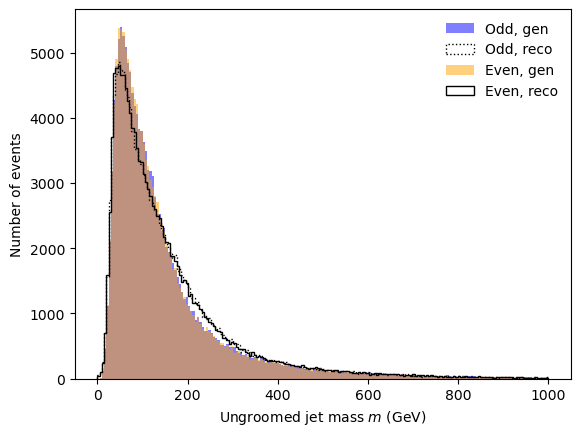

In [12]:
_,_,_=plt.hist(odd_gen[:,0],bins=np.linspace(0,1000,200),color='blue',alpha=0.5,label="Odd, gen")
_,_,_=plt.hist(odd_reco[:,0],bins=np.linspace(0,1000,200),histtype="step",color='black',ls=':',label="Odd, reco")
_,_,_=plt.hist(even_gen[:,0],bins=np.linspace(0,1000,200),color='orange',alpha=0.5,label="Even, gen")
_,_,_=plt.hist(even_reco[:,0],bins=np.linspace(0,1000,200),histtype="step",color='black',label="Even, reco")
plt.xlabel("Ungroomed jet mass $m$ (GeV)")
plt.ylabel("Number of events")
plt.legend(frameon=False)



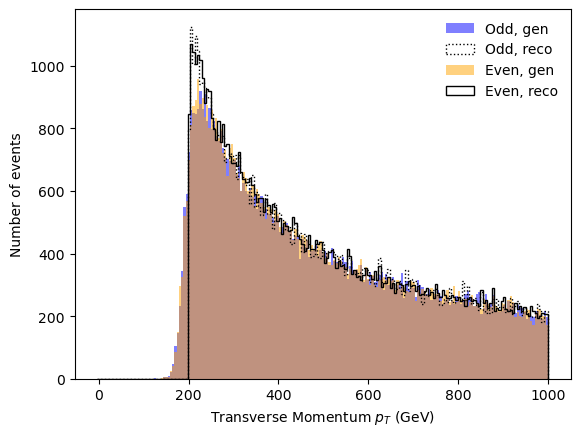

In [13]:
_,_,_=plt.hist(odd_gen[:,1],bins=np.linspace(-3,1000,200),color='blue',alpha=0.5,label="Odd, gen")
_,_,_=plt.hist(odd_reco[:,1],bins=np.linspace(-3,1000,200),histtype="step",color='black',ls=':',label="Odd, reco")
_,_,_=plt.hist(even_gen[:, 1],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Even, gen")
_,_,_=plt.hist(even_reco[:, 1],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Even, reco")
plt.xlabel("Transverse Momentum $p_{T}$ (GeV)")
plt.ylabel("Number of events")
plt.legend(frameon=False)


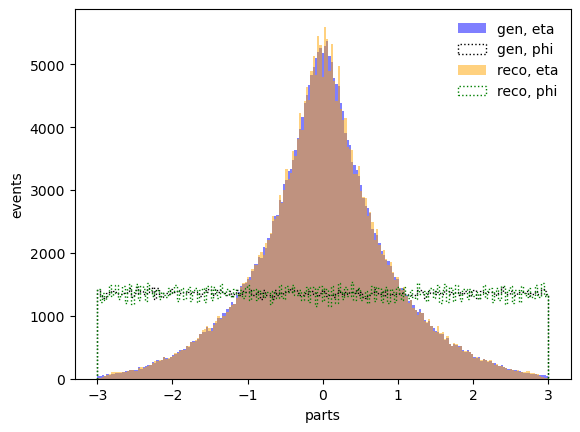

In [14]:
_,_,_=plt.hist(gj0.eta.compute(),bins=np.linspace(-3,3,200),color='blue',alpha=0.5,label="gen, eta")
_,_,_=plt.hist(gj0.phi.compute(),bins=np.linspace(-3,3,200),histtype="step",color='black',ls=':',label="gen, phi")
_,_,_=plt.hist(fj0.eta.compute(),bins=np.linspace(-3,3,200),color='orange',alpha=0.5,label="reco, eta")
_,_,_=plt.hist(fj0.phi.compute(),bins=np.linspace(-3,3,200),histtype="step",color='green',ls=':',label="reco, phi")
#_,_,_=plt.hist(jet_genmass[:],bins=np.linspace(-3,1000,200),color='orange',alpha=0.5,label="Data, true")
#_,_,_=plt.hist(jet_genpt[:],bins=np.linspace(-3,1000,200),histtype="step",color='black',label="Data, reco")
plt.xlabel("parts")
plt.ylabel("events")
plt.legend(frameon=False)

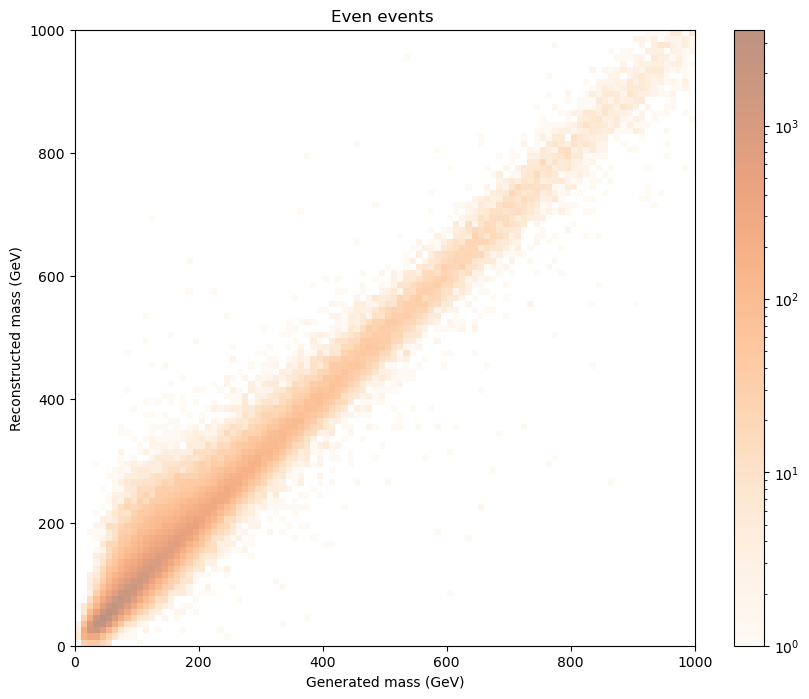

In [15]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(even_gen[:,0], even_reco[:,0], 
           bins=(np.linspace(0,1000,101), np.linspace(0,1000,101)), 
           cmap='Oranges', alpha=0.5, label="Data, true",
           norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel("Generated mass (GeV)")
plt.ylabel("Reconstructed mass (GeV)")
plt.title("Even events ")
plt.show()

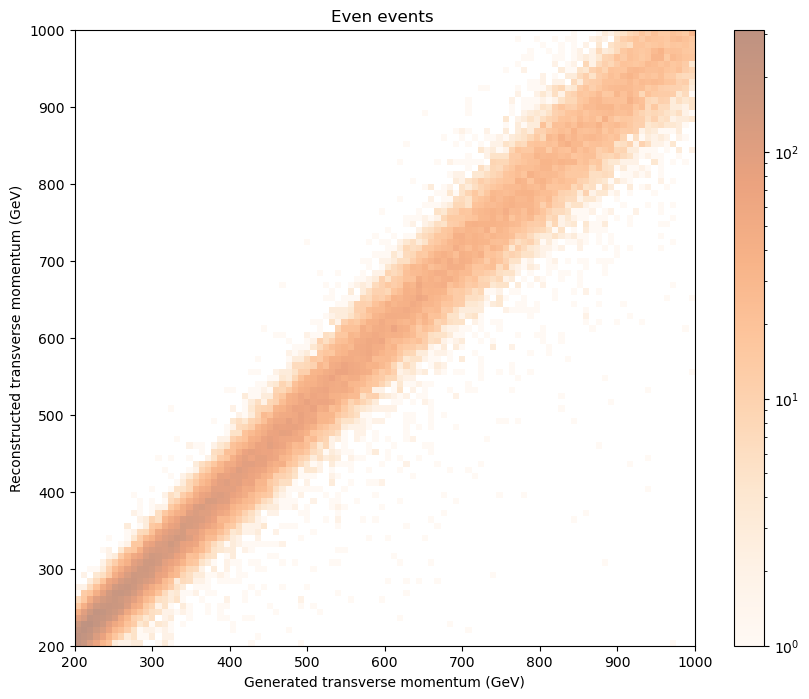

In [16]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(even_gen[:,1], even_reco[:,1], 
           bins=(np.linspace(200,1000,101), np.linspace(200,1000,101)), 
           cmap='Oranges', alpha=0.5, label="Data, true",
           norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlabel("Generated transverse momentum (GeV)")
plt.ylabel("Reconstructed transverse momentum (GeV)")
plt.title("Even events ")
plt.show()

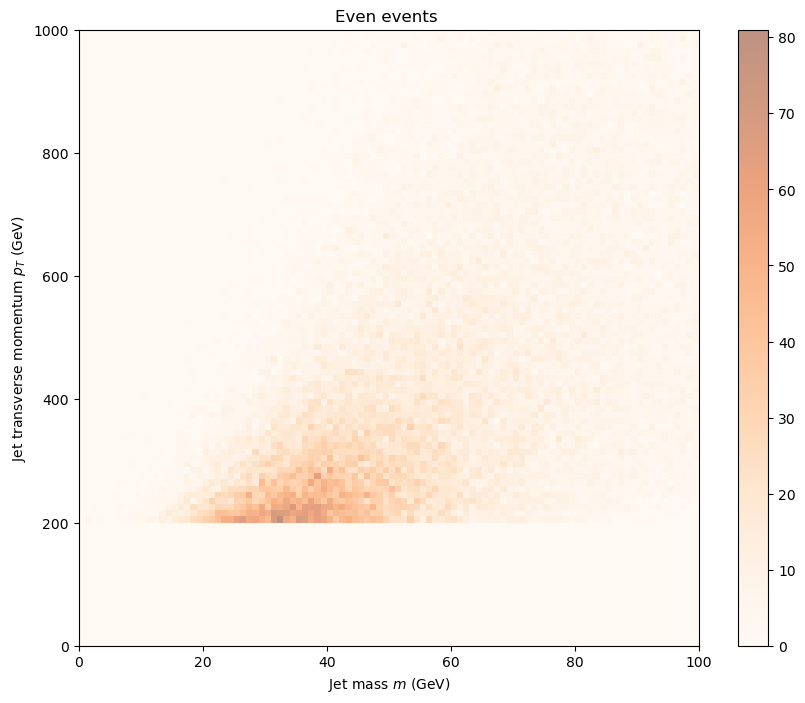

In [17]:
#Data, true
plt.figure(figsize=(10, 8))
plt.hist2d(even_reco[:, 0], even_reco[:, 1], bins=(np.linspace(0,100,101), np.linspace(0,1000,101)), cmap='Oranges', alpha=0.5, label="Data, true")
plt.colorbar()
plt.xlabel("Jet mass $m$ (GeV)")
plt.ylabel("Jet transverse momentum $p_T$ (GeV)")
plt.title("Even events ")
plt.show()

In [18]:
data = DataLoader(reco = even_reco,normalize=True)
mc = DataLoader(reco = odd_reco,gen = odd_gen,normalize=True)

INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Normalizing sum of weights to 1000000 ...
INFO: Creating weights ...
INFO: Creating pass reco flag ...
INFO: Creating pass gen flag ...
INFO: Normalizing sum of weights to 1000000 ...


/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


(<Figure size 900x900 with 1 Axes>,
 <Axes: xlabel='First Feature [a.u]', ylabel='Normalized number of events'>)

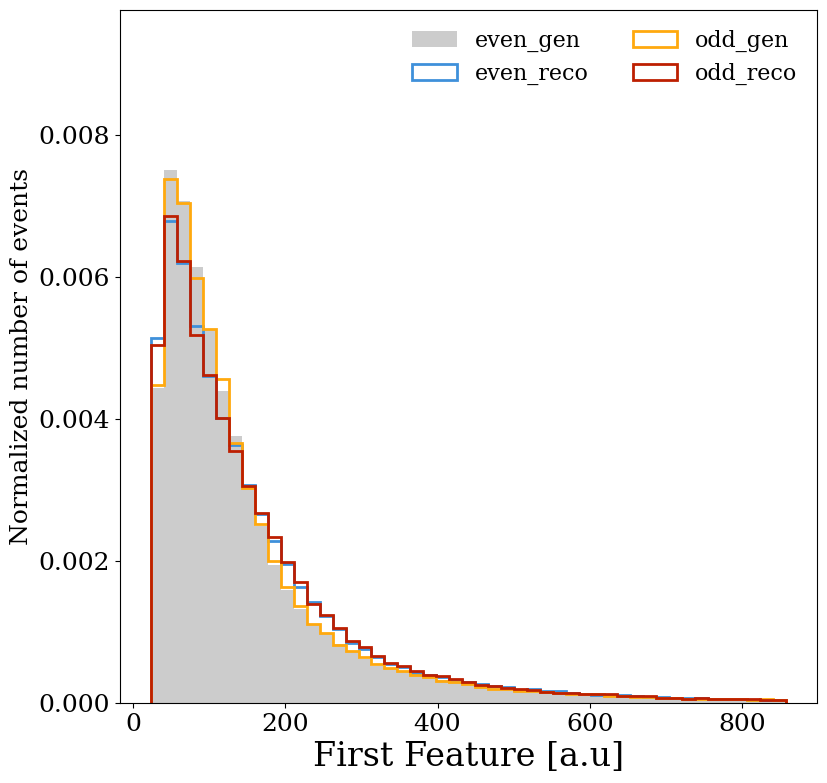

In [19]:
SetStyle()
data_dict = {
    'even_gen': even_gen[:,0],
    'even_reco': even_reco[:,0],
    'odd_gen': odd_gen[:,0],
    'odd_reco': odd_reco[:,0],
}
HistRoutine(data_dict,'First Feature [a.u]', reference_name = 'even_gen',plot_ratio=False)

In [20]:
model1 = MLP(ndim)
model2 = MLP(ndim)

In [21]:
print(model1.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,833 (65.75 KB)

 Trainable params: 16,833 (65.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [22]:
omnifold_instance = MultiFold(
    "PtMass",
    model1,
    model2,
    data,
    mc,
    batch_size = 1024,
    niter = 5,  #Number of Iterations                                                                                                                                                                                                  
    epochs=100,     
    weights_folder = 'weights',
    verbose = True,
)

In [23]:
omnifold_instance.Preprocessing()
omnifold_instance.Unfold()

277 training steps at reco and 277 steps at gen
ITERATION: 1
RUNNING STEP 1
Creating cached data from step 1
################################################################################
Train events used: 283648, Test events used: 56729
################################################################################
Epoch 1/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 15.7233 - val_loss: 5.0494 - learning_rate: 1.0000e-04
Epoch 2/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.0740 - val_loss: 4.9136 - learning_rate: 1.0000e-04
Epoch 3/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.3834 - val_loss: 4.9352 - learning_rate: 1.0000e-04
Epoch 4/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.0982 - val_loss: 4.9282 - learning_rate: 1.0000e-04
Epoch 5/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.0104 - val_loss: 4.9885 - learning_rate: 1.0000e-04
Epoch 6/100
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 5.0169 - val_loss: 4.9772 - learnin

In [26]:
unfolded_weights  = omnifold_instance.reweight(even_gen,omnifold_instance.model2,batch_size=1000)   

143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


`data` is the even events, `mc` is the odd events

In [27]:
print(unfolded_weights)

[0.9917295  0.98061687 1.0141368  ... 0.9780168  0.9850635  0.9662688 ]


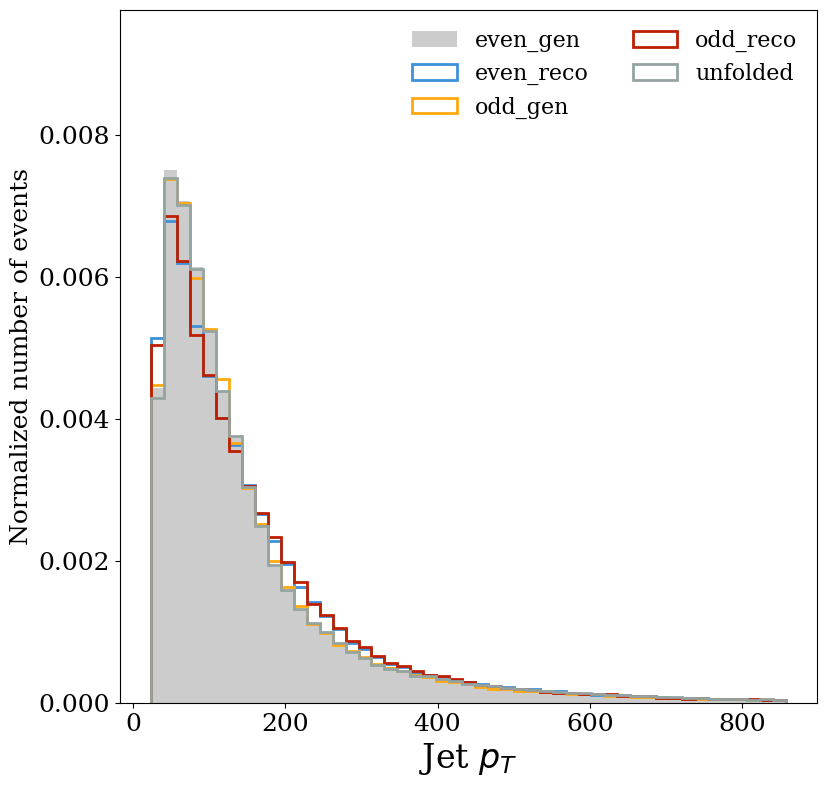

In [33]:
data_dict = {
    'even_gen': even_gen[:,0],
    'even_reco': even_reco[:,0],
    'odd_gen': odd_gen[:,0],
    'odd_reco': odd_reco[:,0],
    'unfolded': even_gen[:,0]
}


weight_dict = {
    'even_gen': data.weight,
    'even_reco': data.weight,
    'odd_gen': mc.weight,
    'odd_reco': mc.weight,
    'unfolded': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict,'Jet $p_{T}$',
                    reference_name = 'even_gen',
                    weights = weight_dict,
                    plot_ratio = False
                    )

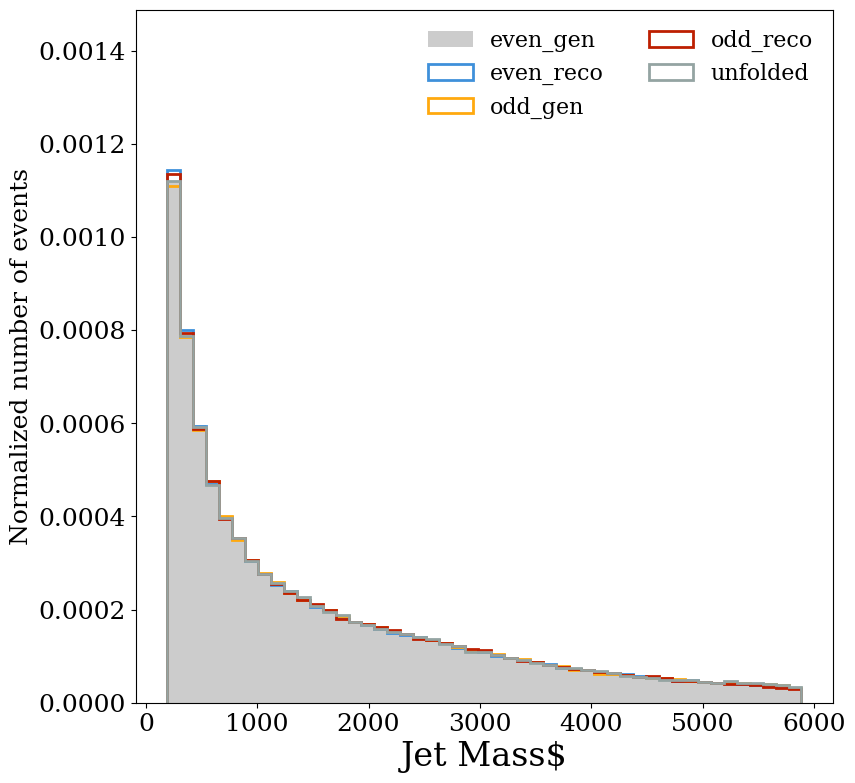

In [34]:
data_dict_mass = {
    'even_gen': even_gen[:,1],
    'even_reco': even_reco[:,1],
    'odd_gen': odd_gen[:,1],
    'odd_reco': odd_reco[:,1],
    'unfolded': even_gen[:,1]
}


weight_dict_mass = {
    'even_gen': data.weight,
    'even_reco': data.weight,
    'odd_gen': mc.weight,
    'odd_reco': mc.weight,
    'unfolded': unfolded_weights,
    }

fig,_ = HistRoutine(data_dict_mass,'Jet Mass$',
                    reference_name = 'even_gen',
                    weights = weight_dict_mass,
                    plot_ratio = False
                    )